In [1]:
import pandas as pd

dataset = pd.read_csv('student_lifestyle_100k.csv')
dataset['Gender'] = dataset['Gender'].astype('category')
dataset['Department'] = dataset['Department'].astype('category')
dataset['Stress_Level'] = dataset['Stress_Level'].astype('category')

In [2]:
# Aufteilen nach True und False in der Spalte Depression
depressed = dataset[dataset['Depression']]
not_depressed = dataset[~dataset['Depression']]

# 10.000 zufällige negative Stichproben ziehen
not_depressed_sample = not_depressed.sample(n=10062, random_state=42)

# Datensatz zusammensetzen
balanced_dataset = pd.concat([depressed, not_depressed_sample])

x = balanced_dataset.loc[:, 'Age':'Stress_Level']
y = balanced_dataset['Depression']

In [3]:
import torch

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(42)  # set random seed for reproducibility

# Spaltennamen nach Typ trennen
categorical_cols = x.select_dtypes(include=['category']).columns.tolist()
numeric_cols = x.select_dtypes(include=['number', 'bool']).columns.tolist()

# Preprocessing-Transformer (numerisch: RobustScaler, kategorisch: OneHotEncoder)
preprocessor = ColumnTransformer([
    ("numeric", RobustScaler(), numeric_cols), # evtl. TargetEncoding für Department
    ("categorical", OneHotEncoder(drop='first'), categorical_cols)
])


x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.4, random_state=42, stratify=y
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

x_train_scaled = preprocessor.fit_transform(x_train)
x_val_scaled = preprocessor.transform(x_val)
x_test_scaled = preprocessor.transform(x_test)

# auto detect input dimension after preprocessing
input_dim = x_train_scaled.shape[1]

batch_size = 16
train_loader = DataLoader(TensorDataset(torch.FloatTensor(x_train_scaled), torch.FloatTensor(y_train.values).view(-1, 1)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.FloatTensor(x_val_scaled), torch.FloatTensor(y_val.values).view(-1, 1)), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(x_test_scaled), torch.FloatTensor(y_test.values).view(-1, 1)), batch_size=batch_size, shuffle=False)

print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches per epoch: 755
Validation batches: 252
Test batches: 252


/tmp/ipykernel_28937/929742574.py:36: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:213.)
  train_loader = DataLoader(TensorDataset(torch.FloatTensor(x_train_scaled), torch.FloatTensor(y_train.values).view(-1, 1)), batch_size=batch_size, shuffle=True)


/\ Allgemeiner Code

\\/ Spezieller Code für das Hyperparameter Tuning

In [4]:
import torch.nn as nn

class FlexibleClassifier(nn.Module):
    """
    Flexible neural network that can be configured with different architectures.
    Supports variable depth and layer dimensions.
    """
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        """
        Args:
            input_dim: Number of input features
            hidden_dims: List of hidden layer dimensions, e.g., [64, 32]
            output_dim: Number of output classes
            dropout_rate: Dropout probability
        """
        super().__init__()
        
        # Build layers dynamically
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim)) # add normalization
            layers.append(nn.LeakyReLU(0.1)) # LeakyReLU instead of ReLU
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

In [5]:
import optuna

def train_epoch(model, train_loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        train_loss += loss.item() * batch_X.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
    
    avg_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, data_loader, criterion):
    """Evaluate the model"""
    model.eval()
    eval_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            eval_loss += loss.item() * batch_X.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
    
    avg_loss = eval_loss / len(data_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy

def train_model(model, train_loader, val_loader, num_epochs=100, lr=0.01, weight_decay=0.0, patience=15, trial=None):
    """Complete training loop"""
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_acc = 0.0
    best_epoch = 0
    patience_counter = 0
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer) # Train
        val_loss, val_acc = evaluate(model, val_loader, criterion)  # Validate
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
        if trial is not None:
            trial.report(val_acc, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()
    
    return best_val_acc, best_epoch

In [6]:
def objective(trial):
    """
    Objective function for Optuna to optimize.
    Returns the best validation accuracy for this hyperparameter configuration.
    """
    # Define the search space
    n_layers = trial.suggest_int('n_layers', 1, 4)
    hidden_dims = []
    for i in range(n_layers):
        dim = trial.suggest_categorical(f'hidden_dim_layer_{i}', [32, 64, 128, 256])
        hidden_dims.append(dim)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)    
    
    # Training the model with the sampled hyperparameters
    model = FlexibleClassifier(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=1,dropout_rate=dropout_rate)        
    best_val_acc, best_epoch = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=learning_rate,
        weight_decay=weight_decay,
        trial=trial  # For Optuna pruning
    )
    
    return best_val_acc

In [7]:
study = optuna.create_study(
    direction='maximize',
    study_name='depression_classification',
    storage='sqlite:///optuna_depression.db',
    load_if_exists=True,
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=10
    )
)

n_trials = 50
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

[I 2026-02-27 15:41:41,864] A new study created in RDB with name: depression_classification


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-27 15:42:33,261] Trial 0 finished with value: 0.6822360248447205 and parameters: {'n_layers': 2, 'hidden_dim_layer_0': 128, 'hidden_dim_layer_1': 32, 'weight_decay': 0.007140919754640818, 'learning_rate': 0.00020930554455085367, 'dropout_rate': 0.25266239204137514}. Best is trial 0 with value: 0.6822360248447205.
[I 2026-02-27 15:42:59,376] Trial 1 finished with value: 0.600248447204969 and parameters: {'n_layers': 4, 'hidden_dim_layer_0': 128, 'hidden_dim_layer_1': 64, 'hidden_dim_layer_2': 256, 'hidden_dim_layer_3': 256, 'weight_decay': 0.004589645129277818, 'learning_rate': 0.019963135485271486, 'dropout_rate': 0.3000823845914477}. Best is trial 0 with value: 0.6822360248447205.
[I 2026-02-27 15:43:17,123] Trial 2 finished with value: 0.6804968944099379 and parameters: {'n_layers': 1, 'hidden_dim_layer_0': 128, 'weight_decay': 0.000841318321868347, 'learning_rate': 0.003978398369991766, 'dropout_rate': 0.37382520522987184}. Best is trial 0 with value: 0.6822360248447205.


In [8]:
best_params = study.best_trial.params

n_layers = best_params['n_layers']
hidden_dims = [best_params[f'hidden_dim_layer_{i}'] for i in range(n_layers)]

best_model = FlexibleClassifier(
    input_dim=input_dim,
    hidden_dims=hidden_dims,
    output_dim=1,
    dropout_rate=best_params['dropout_rate']
)

best_val_acc, _ = train_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay'],
)

print(f"  Best validation accuracy: {best_val_acc:.4f}")

  Best validation accuracy: 0.6870


In [20]:
from sklearn.metrics import classification_report

best_model.eval()
with torch.no_grad():
    test_outputs = best_model(torch.FloatTensor(x_test_scaled))
    y_pred = (torch.sigmoid(test_outputs) > 0.5).int().numpy()

target_names = ['Not Depressed', 'Depressed']
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

Not Depressed       0.67      0.70      0.68      2013
    Depressed       0.68      0.66      0.67      2012

     accuracy                           0.68      4025
    macro avg       0.68      0.68      0.68      4025
 weighted avg       0.68      0.68      0.68      4025



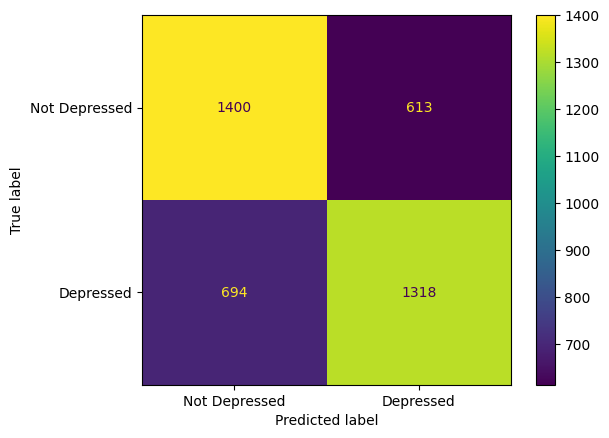

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_names)